### Data Pre-processing Code

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Directory containing the F1 dataset
base_dir = '/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/'

# Load race results and calendar data for each year (2019-2024)
years = range(2019, 2025)
race_results_data = []
calendar_data = []

for year in years:
    race_results_file = f'{base_dir}/{year}/formula1_{year}season_raceResults.csv'
    calendar_file = f'{base_dir}/{year}/formula1_{year}season_calendar.csv'
    
    race_results = pd.read_csv(race_results_file)
    calendar = pd.read_csv(calendar_file)
    
    # Add year column to both datasets
    race_results['Year'] = year
    calendar['Year'] = year
    
    race_results_data.append(race_results)
    calendar_data.append(calendar)

# Concatenate data from all years
race_results_data = pd.concat(race_results_data, ignore_index=True)
calendar_data = pd.concat(calendar_data, ignore_index=True)

# Convert Race Date to datetime in calendar data
calendar_data['Race Date'] = pd.to_datetime(calendar_data['Race Date'], format='%d/%m/%Y', errors='coerce')

# Ensure 'Position' is numeric in race results data
race_results_data['Position'] = pd.to_numeric(race_results_data['Position'], errors='coerce')

# Filter for top 3 positions only
podium_data = race_results_data[race_results_data['Position'].isin([1, 2, 3])]

# Merge podium data with calendar data
merged_data = pd.merge(podium_data, calendar_data[['Country', 'Race Date', 'Year', 'GP Name']], 
                       on=['Country', 'Year'], how='left')

# Sort the data by Race Date and then by Position
merged_data = merged_data.sort_values(['Race Date', 'Position'])

# Handle the cancelled race in Italy for 2023
cancelled_race = merged_data[(merged_data['Country'] == 'Italy') & (merged_data['Year'] == 2023) & (merged_data['Race Date'].isna())]
if not cancelled_race.empty:
    print("\nCancelled race detected:")
    print(cancelled_race[['Country', 'Year', 'GP Name']])
    # choose to keep or remove this entry
    merged_data = merged_data.dropna(subset=['Race Date'])
    # Leave as it is
    merged_data.loc[(merged_data['Country'] == 'Italy') & (merged_data['Year'] == 2023) & (merged_data['Race Date'].isna()), 'GP Name'] += ' (Cancelled)'

# Get current date
current_date = datetime.now()

# Filter out future races
merged_data = merged_data[merged_data['Race Date'] <= current_date]

print("\nMerged Data:")
print(merged_data['Year'].value_counts().sort_index())

# Check the date range in the final dataset
print("\nDate range in the final dataset:")
print(merged_data['Race Date'].min(), "-", merged_data['Race Date'].max())

# Print the last few races in the dataset
print("\nLast few races in the dataset:")
print(merged_data.tail(15))

# Check for any races in 2024
print("\nRaces in 2024:")
print(merged_data[merged_data['Year'] == 2024])

# Save the merged data to a CSV file
merged_data.to_csv(f'{base_dir}/merged_race_data.csv', index=False)
print("\nMerged data saved to 'merged_race_data.csv'")


Merged Data:
Year
2019    63
2020    51
2021    66
2022    66
2023    66
2024    42
Name: count, dtype: int64

Date range in the final dataset:
2019-03-17 00:00:00 - 2024-07-28 00:00:00

Last few races in the dataset:
           Country  Position  No           Driver                        Team  \
339          Spain       1.0   1   Max Verstappen  Red Bull Racing Honda RBPT   
340          Spain       2.0   4     Lando Norris            McLaren Mercedes   
341          Spain       3.0  44   Lewis Hamilton                    Mercedes   
342        Austria       1.0  63   George Russell                    Mercedes   
343        Austria       2.0  81    Oscar Piastri            McLaren Mercedes   
344        Austria       3.0  55     Carlos Sainz                     Ferrari   
345  Great Britain       1.0  44   Lewis Hamilton                    Mercedes   
346  Great Britain       2.0   1   Max Verstappen  Red Bull Racing Honda RBPT   
347  Great Britain       3.0   4     Lando Norris   

### BELOW SECTION CONTAINS ALL THE FUNCTIONS WHICH WILL BE USED FREQUENTLY IN THE FURTHER EDA ANALYSIS

In [2]:
import pandas as pd
import os
import numpy as np
import plotly.graph_objects as go

data = {}
base_path = 'F1_Dataset'

for year in range(2019, 2025):
    year_path = os.path.join(base_path, str(year))
    for file in os.listdir(year_path):
        if file.endswith('.csv'):
            key = f"{year}_{file[:-4]}"
            data[key] = pd.read_csv(os.path.join(year_path, file))


#Function to load race results from 2019-2024 which will be used further in the EDA Analysis

def get_race_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_raceResults"
        if key in data:
            year_results = data[key].copy()
            year_results['Year'] = year
            all_results = pd.concat([all_results, year_results], ignore_index=True)
    return all_results

#Function to load qualifying race results from 2019-2024 which will be used further in the EDA Analysis

def get_qualifying_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        # Constructing the file path for qualifying results
        file_path = f"/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/{year}/formula1_{year}season_qualifyingResults.csv"
        try:
            # Read the CSV file
            year_results = pd.read_csv(file_path)
            # Add a year column
            year_results['Year'] = year
            # Concatenate the results
            all_results = pd.concat([all_results, year_results], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Empty data file: {file_path}")
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")
    return all_results


#Function to load race calendars from 2019-2024 which will be used further in the EDA Analysis

def get_races_per_year():
    races_per_year = {}
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_calendar"
        if key in data:
            races_per_year[year] = len(data[key])
    
    return pd.Series(races_per_year)

def clean_position(pos):
    try:
        return int(pos)
    except ValueError:
        return np.nan

In [ ]:
"""import pandas as pd
import numpy as np
import plotly.graph_objects as go

def clean_position(pos):
    try:
        return int(pos)
    except ValueError:
        return np.nan

def get_race_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_raceResults"
        if key in data:
            year_results = data[key].copy()
            year_results['Year'] = year
            all_results = pd.concat([all_results, year_results], ignore_index=True)
    return all_results

def get_qualifying_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        file_path = f"/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/{year}/formula1_{year}season_qualifyingResults.csv"
        try:
            year_results = pd.read_csv(file_path)
            year_results['Year'] = year
            all_results = pd.concat([all_results, year_results], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Empty data file: {file_path}")
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")
    return all_results"""


In [3]:
#Normalizing Team Names Mapping

def get_team_mapping():
    return {
        'Red Bull': ['Red Bull', 'Red Bull Racing', 'Red Bull Racing Honda', 'Red Bull Racing RBPT', 'Red Bull Racing Honda RBPT'],
        'Mercedes': ['Mercedes', 'Mercedes AMG', 'Mercedes-AMG Petronas'],
        'Ferrari': ['Ferrari', 'Scuderia Ferrari'],
        'McLaren': ['McLaren', 'McLaren F1 Team', 'McLaren Renault', 'McLaren Mercedes'],
        'Aston Martin': ['Aston Martin', 'Racing Point', 'Force India', 'Racing Point BWT Mercedes', 'Aston Martin Mercedes', 'Aston Martin Aramco Mercedes'],
        'Alpine': ['Alpine', 'Renault', 'Alpine Renault'],
        'AlphaTauri': ['AlphaTauri', 'Toro Rosso', 'Scuderia Toro Rosso Honda', 'AlphaTauri Honda', 'AlphaTauri RBPT', 'AlphaTauri Honda RBPT', 'RB Honda RBPT'],
        'Kick Sauber': ['Alfa Romeo', 'Sauber', 'Alfa Romeo Racing Ferrari', 'Alfa Romeo Ferrari', 'Kick Sauber Ferrari'],
        'Williams': ['Williams', 'Williams Mercedes'],
        'Haas': ['Haas', 'Haas F1 Team', 'Haas Ferrari'],
    }

def normalize_team_name(team, team_mapping):
    team = team.strip()
    for normalized_name, variations in team_mapping.items():
        if any(variation.lower() == team.lower() for variation in variations):
            return normalized_name
    return team

In [4]:
# Define the traditional colors for each team
team_colors = {
    'Mercedes': '#00D2BE',  
    'Red Bull': '#1E41FF',  
    'Ferrari': '#DC0000',   
    'McLaren': '#FF8700',   
    'Aston Martin': '#006F62',  
    'Alpine': '#0090FF',    
    'AlphaTauri': '#2B4562',  
    'Alfa Romeo': '#900000',  
    'Williams': '#005AFF',  
    'Haas': '#F0D787'
}

In [ ]:
"""def explore_dataset(df, name):
    print(f"Dataset: {name}")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nBasic Statistics:")
    print(df.describe())
    print("\n" + "="*50 + "\n")

# Apply to each dataset
for name, df in data.items():
    explore_dataset(df, name)"""

## BELOW SECTION WILL COVER EDA IN DETAIL

### Number of Races per year

In [5]:
races_count = get_races_per_year()
print("Number of races per year:")
print(races_count)


import plotly.graph_objects as go

def plot_races_per_year():
    races_count = get_races_per_year()
    
    fig = go.Figure(data=[
        go.Bar(x=races_count.index, y=races_count.values)
    ])
    
    fig.update_layout(
        title='Number of Races per Year',
        title_x=0.5,
        xaxis_title='Year',
        yaxis_title='Number of Races',
        height=500
    )
    
    fig.show()

plot_races_per_year()

Number of races per year:
2019    21
2020    17
2021    22
2022    22
2023    23
2024    24
dtype: int64


## Points scored by Teams

In [6]:
def get_team_points_per_year():
    all_results = get_race_results()
    all_results['Points'] = pd.to_numeric(all_results['Points'], errors='coerce')
    team_mapping = get_team_mapping()
    
    # Normalize team names
    all_results['Team'] = all_results['Team'].apply(lambda team: normalize_team_name(team, team_mapping))
    
    # To check for entries that are not mapped correctly
    unmatched = all_results[all_results['Team'].apply(lambda x: x not in team_mapping.keys())]
    if not unmatched.empty:
        print("\nEntries with unmatched team names:")
        print(unmatched)
        print()
    
    # Grouping by year and team and sum of points
    team_points = all_results.groupby(['Year', 'Team'])['Points'].sum().unstack(level='Team')
    return team_points

team_points = get_team_points_per_year()
print("\nTotal points scored by each team per year:")
print(team_points)


Total points scored by each team per year:
Team  AlphaTauri  Alpine  Aston Martin  Ferrari  Haas  Kick Sauber  McLaren  \
Year                                                                          
2019        85.0    91.0          73.0    504.0  28.0         57.0    145.0   
2020       107.0   181.0         210.0    131.0   3.0          8.0    202.0   
2021       142.0   155.0          77.0    322.5   0.0         13.0    274.0   
2022        35.0   170.0          55.0    519.0  33.0         53.0    150.0   
2023        22.0   110.0         266.0    363.0   9.0         16.0    266.0   
2024        28.0    11.0          73.0    319.0  25.0          0.0    345.0   

Team  Mercedes  Red Bull  Williams  
Year                                
2019     739.0     417.0       1.0  
2020     573.0     319.0       0.0  
2021     604.5     578.5      23.0  
2022     495.0     724.0       8.0  
2023     374.0     790.0      26.0  
2024     250.0     371.0       4.0  


## Race Finishing Positions of Top Drivers

In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

def clean_position(pos):
    try:
        return int(pos)
    except ValueError:
        return np.nan

def identify_top_drivers(n=10):
    results = get_race_results()
    results['Points'] = pd.to_numeric(results['Points'], errors='coerce')
    driver_points = results.groupby('Driver')['Points'].sum().sort_values(ascending=False)
    return driver_points.head(n).index.tolist()

# Identify top drivers
top_drivers = identify_top_drivers()
#print("Top drivers:", top_drivers)

# Compare race finishes for top drivers across seasons
position_counts = {driver: [] for driver in top_drivers}

results = get_race_results()
results['Position'] = results['Position'].apply(clean_position)

max_value = results['Position'].max()

for year in range(2019, 2025):
    year_results = results[results['Year'] == year]
    for driver in top_drivers:
        positions = year_results[year_results['Driver'] == driver]['Position'].value_counts().sort_index()
        position_counts[driver].append(positions)

fig = go.Figure()

# Create a color map with unique colors for each driver
color_map = px.colors.qualitative.Plotly
unique_colors = color_map[:len(top_drivers)]

for idx, (driver, yearly_positions) in enumerate(position_counts.items()):
   
    all_positions = [pos for year_positions in yearly_positions for pos in year_positions]
    fig.add_trace(go.Scatter(
        x=list(range(2019, 2025)),
        y=all_positions,
        mode='lines+markers',
        name=driver,
        line=dict(color=unique_colors[idx]),
        marker=dict(size=10)
    ))

fig.update_layout(
    title='Finishing Positions of Top Drivers',
    title_x=0.5,
    xaxis_title='Year',
    yaxis_title='Position',
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    width=1300,
    height=600,
    hovermode='x unified'
)

fig.update_yaxes(
    range=[-max_value * 0.02, max_value * 0.6],
    tickmode='linear',
    dtick=2
)

fig.show()

## Analysis of Qualifying v/s Race Position

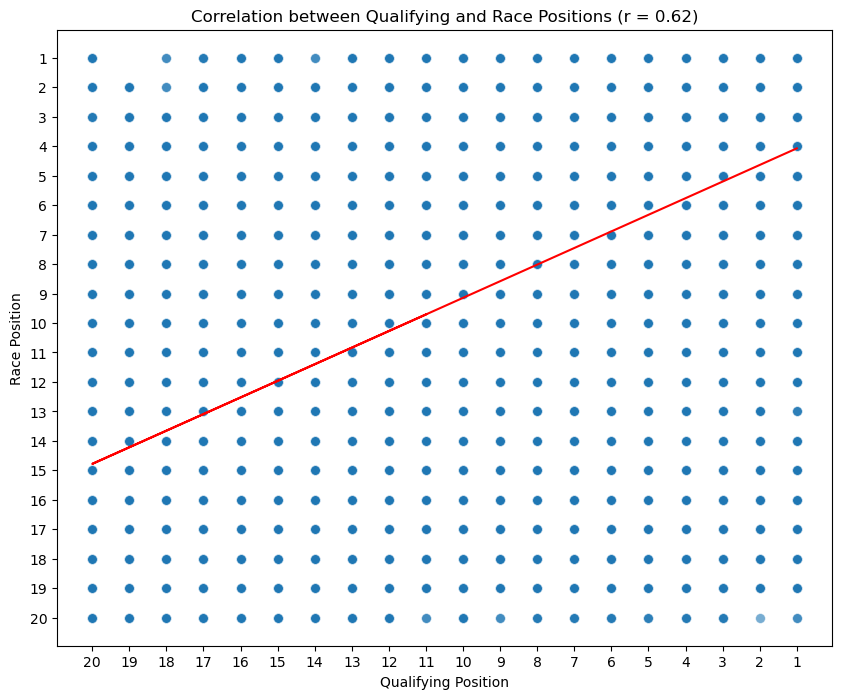

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_correlation_scatter():
    # data retrieval functions
    race_results = get_race_results()
    qualifying_results = get_qualifying_results()
    
    # Merge data
    combined_results = pd.merge(
        qualifying_results[['Driver', 'Team', 'Year', 'Position']],
        race_results[['Driver', 'Team', 'Year', 'Position']],
        on=['Driver', 'Team', 'Year'],
        suffixes=('_Qualifying', '_Race')
    )
    # Convert positions to numeric, replacing non-numeric values with NaN
    combined_results['Position_Qualifying'] = pd.to_numeric(combined_results['Position_Qualifying'], errors='coerce')
    combined_results['Position_Race'] = pd.to_numeric(combined_results['Position_Race'], errors='coerce')

    # Drop rows with NaN values
    combined_results = combined_results.dropna(subset=['Position_Qualifying', 'Position_Race'])
    
    # Calculate correlation
    correlation, _ = stats.pearsonr(combined_results['Position_Qualifying'], combined_results['Position_Race'])
    
    # scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Position_Qualifying', y='Position_Race', data=combined_results, alpha=0.6, s=50)
    
    plt.title(f'Correlation between Qualifying and Race Positions (r = {correlation:.2f})')
    plt.xlabel('Qualifying Position')
    plt.ylabel('Race Position')
    x = combined_results['Position_Qualifying']
    y = combined_results['Position_Race']
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')
    max_pos = max(combined_results['Position_Qualifying'].max(), combined_results['Position_Race'].max())
    plt.xticks(range(1, int(max_pos) + 1))
    plt.yticks(range(1, int(max_pos) + 1))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

plot_correlation_scatter()

## Wins from POLE Position

In [9]:
def analyze_wins_from_pole():
    qualifying_results = get_qualifying_results()
    race_results = get_race_results()
    
    # Load and combine calendar data from multiple files
    calendar = pd.DataFrame()
    for year in range(2019, 2025):
        file_name = f'/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/{year}/formula1_{year}season_calendar.csv'
        if os.path.exists(file_name):
            year_data = pd.read_csv(file_name)
            year_data['Year'] = year
            calendar = pd.concat([calendar, year_data], ignore_index=True)
    
    if qualifying_results.empty or race_results.empty or calendar.empty:
        print("One or more required datasets are empty.")
        return
    
    # Rename columns in calendar DataFrame
    calendar = calendar.rename(columns={
        'GP Name': 'Race',
        'Circuit Name': 'Track'
    })
    
    # checking if the columns exist
    qual_columns = {'Track', 'Position', 'Driver'}
    race_columns = {'Country', 'Position', 'Driver'}
    calendar_columns = {'Race', 'Track'}
    if not qual_columns.issubset(qualifying_results.columns) or \
       not race_columns.issubset(race_results.columns) or \
       not calendar_columns.issubset(calendar.columns):
        print("One or more datasets are missing required columns.")
        return

    # Rename 'Country' to 'Track' in race_results for consistency
    race_results = race_results.rename(columns={'Country': 'Track'})

    # Merge calendar data with qualifying and race results
    qualifying_results = pd.merge(qualifying_results, calendar[['Race', 'Track', 'Year']], on=['Track', 'Year'], how='left')
    race_results = pd.merge(race_results, calendar[['Race', 'Track', 'Year']], on=['Track', 'Year'], how='left')

    # Identify pole position drivers and race winners
    pole_positions = qualifying_results[qualifying_results['Position'] == '1']
    race_winners = race_results[race_results['Position'] == '1']

    # Calculate wins from pole
    wins_from_pole = 0
    driver_wins = {}

    for _, pole in pole_positions.iterrows():
        winner = race_winners[(race_winners['Track'] == pole['Track']) & 
                              (race_winners['Year'] == pole['Year'])]
        if not winner.empty:
            winner = winner.iloc[0]
            if pole['Driver'] == winner['Driver']:
                wins_from_pole += 1
                driver_wins[pole['Driver']] = driver_wins.get(pole['Driver'], 0) + 1
        else:
            print(f"No race winner data found for {pole['Race']} {pole['Year']}")

    # Create DataFrame for driver wins
    driver_wins_df = pd.DataFrame(list(driver_wins.items()), columns=['Driver', 'Wins_From_Pole'])
    driver_wins_df = driver_wins_df.sort_values('Wins_From_Pole', ascending=False)
    
    return wins_from_pole, driver_wins_df

# Call the function
total_wins, driver_wins_df = analyze_wins_from_pole()

# Display the results
print(f"\nTotal wins from pole position (2019-2024): {total_wins}")
print("\nDriver wins from pole:")
print(driver_wins_df.to_string(index=False))


Total wins from pole position (2019-2024): 50

Driver wins from pole:
         Driver  Wins_From_Pole
 Max Verstappen              33
 Lewis Hamilton               7
Charles Leclerc               5
Valtteri Bottas               2
   Carlos Sainz               2
   Sergio Perez               1


In [10]:
def plot_driver_wins(driver_wins_df):
    driver_wins_df_sorted = driver_wins_df.sort_values('Wins_From_Pole', ascending=False)

    # Plotting bar chart
    fig = px.bar(driver_wins_df_sorted, 
                 x='Driver', 
                 y='Wins_From_Pole',
                 title='Wins from Pole Position by Driver',
                 color_discrete_sequence=[ '#32CD32'])
    
    fig.update_layout(
        title_x=0.5,
        xaxis_title='Driver',
        yaxis_title='Number of Wins',
        height=500,
        width=800
    )
    fig.show()

total_wins, driver_wins_df = analyze_wins_from_pole()

# Create the interactive plot
plot_driver_wins(driver_wins_df)


## F1 Track Analysis

In [11]:
import pandas as pd
import numpy as np
import re

def time_to_seconds(time_str, prev_total=0, avg_lap_time=80):
    """ Convert a time string into total seconds, accounting for cumulative times. """
    if pd.isna(time_str) or time_str in ["DNF", "DNS"]:
        return None
    time_str = str(time_str).strip()

    # Handling lap differences
    if time_str.endswith('lap') or time_str.endswith('laps'):
        laps = int(time_str.split()[0])
        return prev_total + (laps * avg_lap_time)

    # Handling '+X.XXXs' format
    if time_str.startswith('+') and time_str.endswith('s'):
        return prev_total + float(time_str[1:-1])

    # Full time format (for the race winner)
    match = re.match(r'(\d+):(\d+):(\d+)', time_str)
    if match:
        h, m, s = match.groups()
        return int(h) * 3600 + int(m) * 60 + float(s)

    return None  # For other unexpected formats

def position_to_numeric(pos_str):
    """ Convert position string to numeric value """
    if pd.isna(pos_str):
        return None
    pos_str = str(pos_str).strip()
    if pos_str.isdigit():
        return int(pos_str)
    elif pos_str in ["NC", "DQ"]:
        return None
    return None  # For other unexpected formats

def check_required_columns(df, required_columns):
    """ Check if required columns are present in the DataFrame """
    df.columns = df.columns.str.strip()  # Remove any whitespace from column names
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing: {', '.join(missing_columns)}")

def analyze_track_race_times(race_results):
    """ Analyze race results data to generate track statistics """
    if race_results is None or not isinstance(race_results, pd.DataFrame):
        raise ValueError("race_results must be a valid pandas DataFrame")
    
    if race_results.empty:
        raise ValueError("race_results DataFrame is empty")
    
    # Ensure correct column names are used
    check_required_columns(race_results, ['Country', 'Time/Retired', 'Year', 'Position'])
    
    # Rename "70th Anniversary" to "Great Britain"
    race_results['Country'] = race_results['Country'].replace("70th Anniversary", "Great Britain")

    # Function to calculate cumulative race times for each race
    def calculate_race_times(group):
        total_time = 0
        race_times = []
        for time in group['Time/Retired']:
            if time not in ['DNF', 'DNS']:
                time_seconds = time_to_seconds(time, total_time)
                if time_seconds is not None:
                    total_time = time_seconds
                    race_times.append(total_time)
        return pd.Series({
            'RaceTimes': race_times,
            'DNFCount': (group['Time/Retired'] == 'DNF').sum(),
            'DNSCount': (group['Time/Retired'] == 'DNS').sum(),
            'NCCount': (group['Position'] == 'NC').sum(),
            'DQCount': (group['Position'] == 'DQ').sum()
        })

    # Group by 'Country' and 'Year', then calculate race times and other statistics
    grouped_stats = race_results.groupby(['Country', 'Year']).apply(calculate_race_times)

    # Calculate country-level statistics
    track_stats = grouped_stats.groupby(level=0).agg({
        'RaceTimes': lambda x: [item for sublist in x for item in sublist],  
        'DNFCount': 'sum',
        'DNSCount': 'sum',
        'NCCount': 'sum',
        'DQCount': 'sum'
    })

    # Calculate additional statistics
    track_stats['RaceCount'] = grouped_stats.groupby(level=0).size()
    track_stats['AvgRaceTime'] = track_stats['RaceTimes'].apply(lambda x: np.median(x) if len(x) > 0 else np.nan) 
    track_stats['FastestRaceTime'] = track_stats['RaceTimes'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
    track_stats['SlowestRaceTime'] = track_stats['RaceTimes'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)

    # Calculate total InvalidTimeCount and rates
    track_stats['InvalidTimeCount'] = track_stats['DNFCount'] + track_stats['DNSCount'] + track_stats['NCCount'] + track_stats['DQCount']
    total_entries = track_stats['RaceCount'] * 20  # Assuming 20 entries per race
    track_stats['DNFRate'] = track_stats['DNFCount'] / total_entries
    track_stats['DNSRate'] = track_stats['DNSCount'] / total_entries
    track_stats['InvalidTimeRate'] = track_stats['InvalidTimeCount'] / total_entries

    # Convert count columns to integers
    integer_columns = ['DNFCount', 'DNSCount', 'NCCount', 'DQCount', 'InvalidTimeCount']
    for col in integer_columns:
        track_stats[col] = track_stats[col].astype(int)

    # Clean up and sort
    track_stats = track_stats.drop('RaceTimes', axis=1).reset_index()

    # Reorder the columns as requested
    column_order = [
        'Country', 'RaceCount', 'AvgRaceTime', 'FastestRaceTime', 'SlowestRaceTime',
        'DNFCount', 'DNSCount', 'NCCount', 'DQCount', 'InvalidTimeCount',
        'DNFRate', 'DNSRate', 'InvalidTimeRate'
    ]
    
    # Reorder the columns and sort by AvgRaceTime
    track_stats = track_stats[column_order].sort_values('AvgRaceTime')

    return track_stats

# Main execution
if __name__ == "__main__":
    try:
        # Get race results
        race_results = get_race_results()
        race_results['Country'] = race_results['Country'].replace("70th Anniversary", "Great Britain")

        # Reset index to ensure 'Country' is a column
        race_results = race_results.reset_index(drop=True)

        # If there's a MultiIndex, flatten it
        if isinstance(race_results.columns, pd.MultiIndex):
            race_results.columns = ['_'.join(col).strip() for col in race_results.columns.values]

        # Ensure 'Country' is a column name
        if 'Country' not in race_results.columns:
            raise ValueError("'Country' column is missing from the DataFrame")

        # Perform the analysis
        track_stats = analyze_track_race_times(race_results)

        # Print detailed results with custom formatting
        print("Track Race Statistics:")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.float_format', '{:.6f}'.format)
        
        # Custom formatting to display integer columns without decimal places
        integer_columns = ['DNFCount', 'DNSCount', 'NCCount', 'DQCount', 'InvalidTimeCount']
        for col in integer_columns:
            track_stats[col] = track_stats[col].apply(lambda x: f"{x:d}")

        print(track_stats.to_string(index=False))

    except ValueError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: Missing key in data dictionary - {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

Track Race Statistics:
       Country  RaceCount  AvgRaceTime  FastestRaceTime  SlowestRaceTime DNFCount DNSCount NCCount DQCount InvalidTimeCount  DNFRate  DNSRate  InvalidTimeRate
         Italy          5  4968.964500      4421.000000      6766.317000       16        2      18       0               36 0.160000 0.020000         0.360000
       Belgium          6  5222.891500       207.000000      6489.336000       11        1      10       1               23 0.091667 0.008333         0.191667
  Saudi Arabia          4  5370.211000      4843.000000      8345.128000       14        2      15       0               31 0.175000 0.025000         0.387500
 Great Britain          6  5449.089000      4782.000000      8527.167000       18        2      19       0               39 0.150000 0.016667         0.325000
        Styria          2  5469.084000      4939.000000      6589.084000        5        0       5       0               10 0.125000 0.000000         0.250000
       Austria         

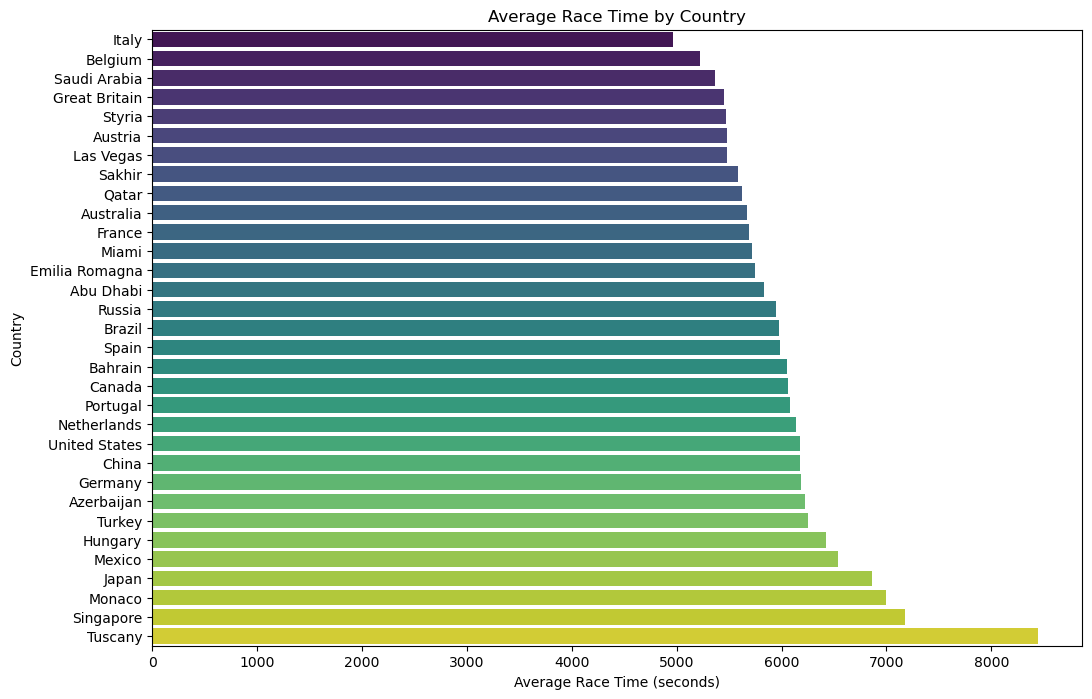

In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x='AvgRaceTime', y='Country', data=track_stats, palette='viridis')
plt.title('Average Race Time by Country')
plt.xlabel('Average Race Time (seconds)')
plt.ylabel('Country')
plt.show()

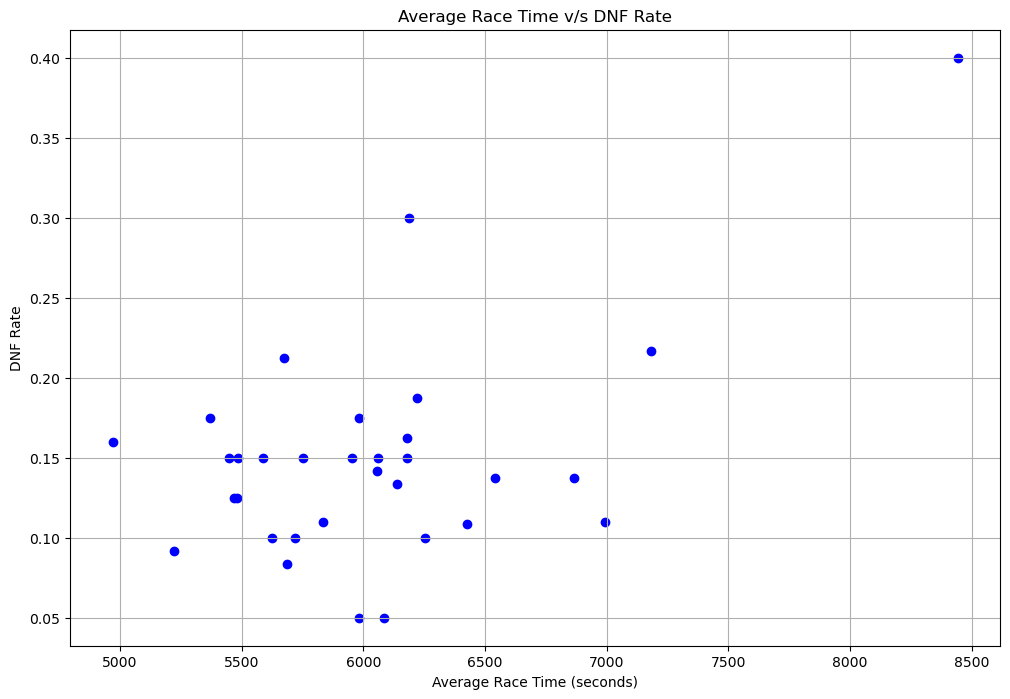

In [13]:
# Scatter Plot Average Race Time vs DNF Rate

plt.figure(figsize=(12, 8))
plt.scatter(track_stats['AvgRaceTime'], track_stats['DNFRate'], color='blue')
plt.title('Average Race Time v/s DNF Rate')
plt.xlabel('Average Race Time (seconds)')
plt.ylabel('DNF Rate')
plt.grid(True)
plt.show()


In [14]:

columns_to_convert = ['DNFCount', 'DNSCount', 'NCCount', 'DQCount']
for col in columns_to_convert:
    track_stats[col] = pd.to_numeric(track_stats[col], errors='coerce')

# Prepare data for plotting
outcomes = track_stats[['Country'] + columns_to_convert].set_index('Country')

# Create the stacked bar chart
fig = go.Figure()

for column in columns_to_convert:
    fig.add_trace(go.Bar(
        x=outcomes.index,
        y=outcomes[column],
        name=column
    ))

# Update layout
fig.update_layout(
    title='Count of Different Race Outcomes by Country',
    title_x=0.5,
    xaxis_title='Country',
    yaxis_title='Count',
    barmode='stack',
    xaxis_tickangle=-90,
    legend_title='Outcome',
    height=600,
    width=1300
)

fig.show()

In [15]:

track_stats = track_stats.rename(columns={'FastestRaceTime': 'Fastest Race Time', 'SlowestRaceTime': 'Slowest Race Time'})

# Define adjusted colors for the bars
adjusted_colors = {
    'Fastest Race Time': '#87CEEB',  # SkyBlue color
    'Slowest Race Time': 'lightcoral'
}

fig = px.bar(track_stats, x='Country', y=['Fastest Race Time', 'Slowest Race Time'],
             labels={'value': 'Race Time (s)', 'variable': 'Race Time Type'},
             title='Fastest vs. Slowest Race Times by Country',
             hover_data=['DNFCount', 'DNSCount'],
             color_discrete_map=adjusted_colors)

# Center the title
fig.update_layout(title={'x': 0.5})
fig.show()


In [16]:

fig = px.scatter(track_stats, x='DNFRate', y='DNSRate', 
                 size='RaceCount', color='AvgRaceTime',
                 hover_name='Country', 
                 labels={'DNFRate': 'Did Not Finish Rate', 
                         'DNSRate': 'Did Not Start Rate',
                         'RaceCount': 'Number of Races',
                         'AvgRaceTime': 'Average Race Time (s)'},
                 title='DNF Rate vs. DNS Rate')


fig.update_layout(title={'x': 0.5})
fig.show()


## Team Performance Analysis: Qualifying Race

In [17]:
from collections import defaultdict
from tabulate import tabulate

def analyze_qualifying_performance(qualifying_df, team_mapping, track_col='Track', team_col='Team', driver_col='Driver', position_col='Position', year_col='Year'):
    # Checking if the required columns exist
    required_columns = [track_col, team_col, driver_col, position_col, year_col]
    missing_columns = [col for col in required_columns if col not in qualifying_df.columns]
    if missing_columns:
        print(f"Error: The following required columns are missing: {', '.join(missing_columns)}")
        return

    # Normalize team names
    qualifying_df['NormalizedTeam'] = qualifying_df[team_col].apply(lambda x: normalize_team_name(x, team_mapping))
    qualifying_df['NumericPosition'] = pd.to_numeric(qualifying_df[position_col], errors='coerce')
    
    teams = qualifying_df['NormalizedTeam'].unique()
    
    for team in teams:
        print(f"\nQualifying Analysis for {team}:")
        print("=" * 40)
        
        team_data = qualifying_df[qualifying_df['NormalizedTeam'] == team]
        total_qualifyings = len(team_data.groupby([year_col, track_col]))
        total_pole_positions = len(team_data[team_data['NumericPosition'] == 1])
        total_front_row_starts = len(team_data[team_data['NumericPosition'].isin([1, 2])])
        total_top_5_starts = len(team_data[team_data['NumericPosition'].isin([1, 2, 3, 4, 5])])
        total_q3_appearances = len(team_data[team_data['NumericPosition'] <= 10])
        
        best_position = team_data['NumericPosition'].min()
        if pd.isna(best_position):
            best_position = 'N/A'
        else:
            best_position = int(best_position)
        
        print("Overall Statistics:")
        print(f"Total Qualifying Sessions: {total_qualifyings}")
        print(f"Total Pole Positions: {total_pole_positions}")
        print(f"Total Front Row Starts: {total_front_row_starts}")
        print(f"Total Top 5 Starts: {total_top_5_starts}")
        print(f"Total Q3 Appearances: {total_q3_appearances}")
        print(f"Best Qualifying Position: {best_position}")
        
        # Count pole positions for each driver and year
        driver_poles = defaultdict(lambda: defaultdict(int))
        pole_data = team_data[team_data['NumericPosition'] == 1]
        for _, row in pole_data.iterrows():
            driver = row[driver_col]
            year = row[year_col]
            driver_poles[year][driver] += 1
        
        if driver_poles:
            print("\nPole Positions by Year and Driver:")
            table_data = []
            for year in sorted(driver_poles.keys()):
                drivers = sorted(driver_poles[year].items(), key=lambda x: x[1], reverse=True)
                for i, (driver, poles) in enumerate(drivers):
                    if i == 0:
                        table_data.append([year, driver, poles])
                    else:
                        table_data.append(["", driver, poles])
            
            headers = ["Year", "Driver", "Pole Positions"]
            table = tabulate(table_data, headers=headers, tablefmt="grid")
            print(table)
        
        # Top 5 Best Performing Tracks in Qualifying
        track_performance = team_data.groupby(track_col).agg({
            'NumericPosition': [
                ('Pole Positions', lambda x: (x == 1).sum()),
                ('Front Row Starts', lambda x: x.isin([1, 2]).sum())
            ]
        }).reset_index()

        track_performance.columns = [track_col, 'Pole Positions', 'Front Row Starts']
        best_tracks = track_performance.nlargest(5, ['Pole Positions', 'Front Row Starts'])
        
        print("\nTop 5 Best Performing Tracks in Qualifying:")
        track_table = tabulate(best_tracks, headers='keys', tablefmt="grid", showindex=False)
        print(track_table)


# Main execution
if __name__ == "__main__":
    qualifying_df = get_qualifying_results()
    team_mapping = get_team_mapping()
    
    # Running the analysis with the correct column names
    analyze_qualifying_performance(qualifying_df, team_mapping, 
                                   track_col='Track', 
                                   team_col='Team', 
                                   driver_col='Driver', 
                                   position_col='Position', 
                                   year_col='Year')


Qualifying Analysis for Mercedes:
Overall Statistics:
Total Qualifying Sessions: 117
Total Pole Positions: 38
Total Front Row Starts: 84
Total Top 5 Starts: 156
Total Q3 Appearances: 217
Best Qualifying Position: 1

Pole Positions by Year and Driver:
+--------+-----------------+------------------+
| Year   | Driver          |   Pole Positions |
+========+=================+==================+
| 2019   | Lewis Hamilton  |                5 |
+--------+-----------------+------------------+
|        | Valtteri Bottas |                5 |
+--------+-----------------+------------------+
| 2020   | Lewis Hamilton  |               10 |
+--------+-----------------+------------------+
|        | Valtteri Bottas |                4 |
+--------+-----------------+------------------+
| 2021   | Lewis Hamilton  |                7 |
+--------+-----------------+------------------+
|        | Valtteri Bottas |                3 |
+--------+-----------------+------------------+
| 2022   | George Russell  |

In [18]:

def visualize_qualifying_performance(qualifying_df, team_mapping):
    # Normalize team names
    qualifying_df['NormalizedTeam'] = qualifying_df['Team'].apply(lambda x: normalize_team_name(x, team_mapping))
    
    # Convert Position to numeric, treating non-numeric values as NaN
    qualifying_df['NumericPosition'] = pd.to_numeric(qualifying_df['Position'], errors='coerce')
    
    # 1. Cumulative Pole Positions by Team
    pole_positions = qualifying_df[qualifying_df['NumericPosition'] == 1].groupby(['Year', 'NormalizedTeam']).size().unstack(fill_value=0).cumsum()
    fig1 = go.Figure()
    for team in pole_positions.columns:
        fig1.add_trace(go.Scatter(x=pole_positions.index, y=pole_positions[team],
                                  mode='lines+markers', name=team,
                                  line=dict(color=team_colors.get(team, '#000000'))))
    fig1.update_layout(title='Cumulative Pole Positions by Team',
                       title_x=0.5,
                       xaxis_title='Year', yaxis_title='Cumulative Pole Positions')
    fig1.show()

    # 2. Total Pole Positions by Team
    total_poles = pole_positions.iloc[-1].sort_values(ascending=False)
    fig2 = go.Figure(go.Bar(x=total_poles.index, y=total_poles.values,
                            marker_color=[team_colors.get(team, '#000000') for team in total_poles.index]))
    fig2.update_layout(title='Total Pole Positions by Team',
                       title_x=0.5,
                       xaxis_title='Team', yaxis_title='Total Pole Positions')
    fig2.show()

    # 3. Top 10 Drivers by Pole Positions (Line Plot)
    driver_poles = qualifying_df[qualifying_df['NumericPosition'] == 1].groupby(['Driver', 'Year']).size().unstack(fill_value=0)
    driver_poles['Total'] = driver_poles.sum(axis=1)
    top_drivers = driver_poles.nlargest(10, 'Total')
    fig3 = go.Figure()
    for driver in top_drivers.index:
        fig3.add_trace(go.Scatter(x=top_drivers.columns[:-1], y=top_drivers.loc[driver, top_drivers.columns[:-1]],
                                  mode='lines+markers', name=driver))
    fig3.update_layout(title='Top 10 Drivers by Pole Positions',
                       title_x=0.5,
                       xaxis_title='Year', yaxis_title='Pole Positions')
    fig3.show()

    # 4. Team Performance in Qualifying
    team_performance = qualifying_df.groupby('NormalizedTeam').agg({
        'NumericPosition': [('Q3', lambda x: (x <= 10).sum()),
                            ('Front_Row', lambda x: (x <= 2).sum()),
                            ('Pole', lambda x: (x == 1).sum())]
    })
    team_performance.columns = ['Q3_Appearances', 'Front_Row_Starts', 'Pole_Positions']
    fig4 = go.Figure()
    for team in team_performance.index:
        fig4.add_trace(go.Scatter(x=[team_performance.loc[team, 'Q3_Appearances']],
                                  y=[team_performance.loc[team, 'Front_Row_Starts']],
                                  mode='markers',
                                  marker=dict(size=team_performance.loc[team, 'Pole_Positions']*2,
                                              color=team_colors.get(team, '#000000')),
                                  name=team,
                                  text=[f"{team}<br>Q3 Appearances: {team_performance.loc[team, 'Q3_Appearances']}<br>"
                                        f"Front Row Starts: {team_performance.loc[team, 'Front_Row_Starts']}<br>"
                                        f"Pole Positions: {team_performance.loc[team, 'Pole_Positions']}"],
                                  hoverinfo='text'))
    fig4.update_layout(title='Team Performance in Qualifying',
                       title_x=0.5,
                       xaxis_title='Q3 Appearances', yaxis_title='Front Row Starts')
    fig4.show()


# Main execution
if __name__ == "__main__":
    qualifying_df = get_qualifying_results()
    team_mapping = get_team_mapping()
    visualize_qualifying_performance(qualifying_df, team_mapping)


In [19]:
pip install tabulate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Team Performance Analysis: Race Results

In [20]:
import pandas as pd
import numpy as np

def analyze_race_performance(race_df, team_mapping, track_col='Country', team_col='Team', driver_col='Driver', position_col='Position', year_col='Year'):
    # Normalize team names
    race_df['NormalizedTeam'] = race_df[team_col].apply(lambda x: normalize_team_name(x, team_mapping))
    race_df['NumericPosition'] = pd.to_numeric(race_df[position_col], errors='coerce')

    # Rename "70th Anniversary" to "Great Britain"
    race_df[track_col] = race_df[track_col].replace("70th Anniversary", "Great Britain")
    teams = race_df['NormalizedTeam'].unique()
    
    for team in teams:
        print(f"\nRace Analysis for {team}:")
        print("=" * 40)
        
        team_data = race_df[race_df['NormalizedTeam'] == team]
        total_races = len(team_data.groupby([year_col, track_col]))
        total_wins = len(team_data[team_data['NumericPosition'] == 1])
        total_podium_finishes = len(team_data[team_data['NumericPosition'].isin([1, 2, 3])])
        total_top_5_finishes = len(team_data[team_data['NumericPosition'].isin([1, 2, 3, 4, 5])])
        total_points_finishes = len(team_data[team_data['NumericPosition'].between(1, 10)])
        
        best_position = team_data['NumericPosition'].min()
        if pd.isna(best_position):
            best_position = 'N/A'
        else:
            best_position = int(best_position)
        
        
        # Define a list of all non-finish categories
        non_finish_categories = ['NC', 'DQ']

        # Count each type of non-finish
        total_nc = len(team_data[team_data[position_col] == 'NC'])
        total_dq = len(team_data[team_data[position_col] == 'DQ'])

        # Count other non-finishes (any non-numeric position not in the above categories)
        total_other = len(team_data[(~team_data[position_col].isin(non_finish_categories)) & 
                                    team_data['NumericPosition'].isna()])

        print("Overall Statistics:")
        print(f"Total Races: {total_races}")
        print(f"Total Wins: {total_wins}")
        print(f"Total Podium Finishes: {total_podium_finishes}")
        print(f"Total Top 5 Finishes: {total_top_5_finishes}")
        print(f"Total Points Finishes: {total_points_finishes}")
        print(f"Best Position: {best_position}")
        print(f"Total Not Classified (NC): {total_nc}")
        print(f"Total Disqualifications (DQ): {total_dq}")
        print(f"Total Other Non-Finishes: {total_other}")
        
        # Count wins for each driver and year
        driver_wins = defaultdict(lambda: defaultdict(int))
        winning_data = team_data[team_data['NumericPosition'] == 1]
        for _, row in winning_data.iterrows():
            driver = row[driver_col]
            year = row[year_col]
            driver_wins[year][driver] += 1
        
        if driver_wins:
            print("\nWins by Year and Driver:")
            table_data = []
            for year in sorted(driver_wins.keys()):
                drivers = sorted(driver_wins[year].items(), key=lambda x: x[1], reverse=True)
                for i, (driver, wins) in enumerate(drivers):
                    if i == 0:
                        table_data.append([year, driver, wins])
                    else:
                        table_data.append(["", driver, wins])
            
            headers = ["Year", "Driver", "Wins"]
            table = tabulate(table_data, headers=headers, tablefmt="grid")
            print(table)
        
        # Top 5 Best Performing Tracks
        track_performance = team_data.groupby(track_col).agg({
            'NumericPosition': [
                ('Wins', lambda x: (x == 1).sum()),
                ('Podium Finishes', lambda x: x.isin([1, 2, 3]).sum())
            ]
        }).reset_index()

        track_performance.columns = [track_col, 'Wins', 'Podium Finishes']
        best_tracks = track_performance.nlargest(5, ['Wins', 'Podium Finishes'])
        
        print("\nTop 5 Best Performing Tracks:")
        track_table = tabulate(best_tracks, headers='keys', tablefmt="grid", showindex=False)
        print(track_table)


def convert_position(pos):
    try:
        return int(pos)
    except ValueError:
        return pos 
    
# Main execution remains the same
if __name__ == "__main__":
    race_df = get_race_results()
    team_mapping = get_team_mapping()
    
    race_df['Position'] = race_df['Position'].apply(convert_position)
    
    # Renaming "70th Anniversary" to "Great Britain" in the main DataFrame
    race_df['Country'] = race_df['Country'].replace("70th Anniversary", "Great Britain")
    analyze_race_performance(race_df, team_mapping)


Race Analysis for Mercedes:
Overall Statistics:
Total Races: 117
Total Wins: 41
Total Podium Finishes: 116
Total Top 5 Finishes: 162
Total Points Finishes: 206
Best Position: 1
Total Not Classified (NC): 16
Total Disqualifications (DQ): 2
Total Other Non-Finishes: 0

Wins by Year and Driver:
+--------+-----------------+--------+
| Year   | Driver          |   Wins |
+========+=================+========+
| 2019   | Lewis Hamilton  |     11 |
+--------+-----------------+--------+
|        | Valtteri Bottas |      4 |
+--------+-----------------+--------+
| 2020   | Lewis Hamilton  |     11 |
+--------+-----------------+--------+
|        | Valtteri Bottas |      2 |
+--------+-----------------+--------+
| 2021   | Lewis Hamilton  |      8 |
+--------+-----------------+--------+
|        | Valtteri Bottas |      1 |
+--------+-----------------+--------+
| 2022   | George Russell  |      1 |
+--------+-----------------+--------+
| 2024   | Lewis Hamilton  |      2 |
+--------+------------

In [21]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict

def visualize_race_performance(race_df, team_mapping):
    # Normalize team names
    race_df['NormalizedTeam'] = race_df['Team'].apply(lambda x: normalize_team_name(x, team_mapping))
    
    # Convert Position to numeric, treating non-numeric values as NaN
    race_df['NumericPosition'] = pd.to_numeric(race_df['Position'], errors='coerce')
    
    # 1. Cumulative Wins by Team
    wins = race_df[race_df['NumericPosition'] == 1].groupby(['Year', 'NormalizedTeam']).size().unstack(fill_value=0).cumsum()
    fig1 = go.Figure()
    for team in wins.columns:
        fig1.add_trace(go.Scatter(x=wins.index, y=wins[team],
                                  mode='lines+markers', name=team,
                                  line=dict(color=team_colors.get(team, '#000000'))))
    fig1.update_layout(title='Cumulative Wins by Team',
                       title_x=0.5,
                       xaxis_title='Year', yaxis_title='Cumulative Wins')
    fig1.show()

    # 2. Total Wins by Team
    total_wins = wins.iloc[-1].sort_values(ascending=False)
    fig2 = go.Figure(go.Bar(x=total_wins.index, y=total_wins.values,
                            marker_color=[team_colors.get(team, '#000000') for team in total_wins.index]))
    fig2.update_layout(title='Total Wins by Team',
                       title_x=0.5,
                       xaxis_title='Team', yaxis_title='Total Wins')
    fig2.show()

    # 3. Top 10 Drivers by Wins (Line Plot)
    driver_wins = race_df[race_df['NumericPosition'] == 1].groupby(['Driver', 'Year']).size().unstack(fill_value=0)
    driver_wins['Total'] = driver_wins.sum(axis=1)
    top_drivers = driver_wins.nlargest(10, 'Total')
    fig3 = go.Figure()
    for driver in top_drivers.index:
        fig3.add_trace(go.Scatter(x=top_drivers.columns[:-1], y=top_drivers.loc[driver, top_drivers.columns[:-1]],
                                  mode='lines+markers', name=driver))
    fig3.update_layout(title='Top 10 Drivers by Wins',
                       title_x=0.5,  # Center the title
                       xaxis_title='Year', yaxis_title='Wins')
    fig3.show()

    # 4. Team Performance in Races
    team_performance = race_df.groupby('NormalizedTeam').agg({
        'NumericPosition': [('Wins', lambda x: (x == 1).sum()),
                            ('Podiums', lambda x: x.isin([1, 2, 3]).sum()),
                            ('Points', lambda x: x.between(1, 10).sum())]
    })
    team_performance.columns = ['Wins', 'Podiums', 'Points_Finishes']
    fig4 = go.Figure()
    for team in team_performance.index:
        fig4.add_trace(go.Scatter(x=[team_performance.loc[team, 'Points_Finishes']],
                                  y=[team_performance.loc[team, 'Podiums']],
                                  mode='markers',
                                  marker=dict(size=team_performance.loc[team, 'Wins']*2,
                                              color=team_colors.get(team, '#000000')),
                                  name=team,
                                  text=[f"{team}<br>Points Finishes: {team_performance.loc[team, 'Points_Finishes']}<br>"
                                        f"Podiums: {team_performance.loc[team, 'Podiums']}<br>"
                                        f"Wins: {team_performance.loc[team, 'Wins']}"],
                                  hoverinfo='text'))
    fig4.update_layout(title='Team Performance in Races',
                       title_x=0.5,  # Center the title
                       xaxis_title='Points Finishes', yaxis_title='Podiums')
    fig4.show()


# Main execution
if __name__ == "__main__":
    race_df = get_race_results()
    team_mapping = get_team_mapping()
    visualize_race_performance(race_df, team_mapping)
